<a href="https://colab.research.google.com/github/jgarnicaa/MentalHealth/blob/main/2_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1e7ctPi8O3bTQoLZaO9ZZjwGr2r8Z93RS" width="100%">

# Entendimiento y Preparación del Corpus
---

Este notebook tiene como objetivo exponer el dataset a detalle y el preproceso del mismo como parte del proyecto del curso Procesamiento y Entendimiento del Lenguaje Natural.


## Miembros del equipo
- Andrés Camilo Rodríguez Patarroyo
- Carlos Alberto Cortés Ramírez
- Jose Eduardo Garnica Aza

In [1]:
!pip install unidecode
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install polyglot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.4/262.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyicu: filename=PyICU-2.13.1-cp310-cp310-linux_x86_64.whl size=1801403 sha256=15f7da108c64bd7e236ca6c6bf19496f5149fd690e7fcf037bd9e8c42d4f56fb
  Stored in directory: /root/.cache/pip/wheels/8e/45/08/f4bc505e31eb7bb779d493226921abf18cf55ed30142e70eae
Successfully built pyicu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycld2: filename=pycld2-0.41-cp310-cp310-linux_x86_64.whl size=9904030 sha256=22c6d451831b28cf2109ff7fce52bc124c682284276dad80fe1b231abddb5b6b
  Stored in directory: /root/.cache/pip/wheels/be/81/31/240c89c845e008a93d98542325270007de595bfd356eb0b06c
Successfully bui

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
import polyglot
import regex
from polyglot.detect import Detector
from polyglot.text import Text, Word
from polyglot.detect.base import logger as polyglot_logger
from sklearn.feature_extraction.text import CountVectorizer
import re
from unidecode import unidecode
polyglot_logger.setLevel("ERROR")

## **1. Análisis Exploratorio de los Textos**
---

Se cargara el dataset para realizar el análisis exploratorio de los textos, normalmente se trata de dar respuesta a los siguientes elementos:



### **1.1. Resumen General de los Textos**
---

- ¿Cuántos documentos tiene el corpus?
- ¿En qué idioma se encuentran?
- ¿Qué tamaño en MB tiene el corpus?
- ¿Hay alguna relación entre distintos documentos del corpus?

El corpus esta compuesto por un total de 52681 documentos, estos documentos se encuentran enteramente en idioma **Inglés**, se puede ver que el objeto definido como dataset usa 1.273 Mb pero el documento CSV original pesa alrededor de 30Mb. Finalmente se ve una muestra aleatoria de los datos, se puede decir que no hay correlacion directa o de dependencia entre los textos aunque todos se tratan de comentarios o mensajes cortos en un contexto de redes sociales, lo que permite tener una homogeneidad o similitud entre los documentos como se ve en la muestra expuesta, sin embargo, los textos se encuentran ya etiquetados según el tipo de estado emocional de cada uno como se puede ver más adelante.

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/ccortesra/MentalHeatlh/main/Combined%20Data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df.memory_usage().sum()/1000000 #MBytes archivo de 30 mb dataframe de 1.27

1.27316

In [6]:
import random
for i in range(5):
  print(df.statement.iloc[random.randint(1, 1000)])

People expect it's not really that good. .Life is restless. This is how to get rid of it?
there is a task to complain, there is no task to worry, wonder
Motorcycle again haha
I've shifted my focus to something else but I'm still worried
even though I don't do tiring activities but it can get sick -_- I don't understand anymore


In [7]:
# lista de etiquetas en las cuales están clasificados los textos
print(df.status.unique())

['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


### **1.2. Resumen de la Calidad de los Textos**
---

- ¿Hay datos faltantes o documentos vacíos?
- ¿Existen documentos ilegibles o con problemas de codificación?
- ¿Hay mezcla de idiomas en el corpus?, ¿qué se puede hacer al respecto?

En el corpus se puede ver como hay mayor numero de etiquetas en "status" que cantidad de documentos, se puede ver entonces que hay un total de **362** documentos con valores nulos o vacíos en el dataset, de los documentos que si estan presentes se puede ver que no hay ninguno vacio o nulo

En la celda del ciclo for se puede ver todos los documentos que no son codificables a ASCII, la mayor parte de esto es por uso de caracteres especiales, lo cual debe ser corregido en el preprocesado de los datos, se muestra tambien la cantidad de documentos que hay que corregir el cual corresponde a **~11.7%**

In [8]:
# Cantidad de features nulos o vacíos
df.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [9]:
index_ilegibles=[]
for i in range(len(df['statement'].values)):
  try:
    df['statement'].values[i].encode('ascii')
  except:
    print("Ilegible en: "+str(i)+" como: "+str(df['statement'].values[i]))
    index_ilegibles.append(i)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Ilegible en: 50642 como: What to actually do during a depressive episode? Hi! So I’m seeing a psychiatrist for my depression and I might be bipolar. I’m on medication now but it’s not working yet. I have more energy than before, but burned down my studies and social life because of my depression and I still feel like shit.

I’m not bad enough for inpatient and there’s no intensive outpatient where I am and I barely have therapy. I don’t know what to do, I’m glad I’m not just crying, staring into nothingness and sleeping anymore. However, there’s only so much drawing, reading and bingewatching I can do and I feel like I’m slowly going mad with boredom but I don’t know where to find meaning right now. How can I fill my days in a non-toxic way?
Ilegible en: 50643 como: When do I tell him? I’ve been dating this guy for the past nine months. We’re mutually exclusive but not yet bf/gf. I have bipolar 2 disorder and

In [11]:
print("Total de datos: "+str(len(df['statement'].values))+" || Total de datos a limpiar : "+(str(len(index_ilegibles))) + " || Porcentaje: "+str((len(index_ilegibles)/len(df['statement'].values))*100)+"%")

Total de datos: 53043 || Total de datos a limpiar : 6217 || Porcentaje: 11.720679448749129%


A continuación verificaremos si existen otros idiomas en los textos:

In [12]:
RE_BAD_CHARS = regex.compile(r"[\p{Cc}\p{Cs}]+")

def remove_bad_chars(text):
    return RE_BAD_CHARS.sub("", text)

def detect_lang(text):
  text = Detector(remove_bad_chars(text), quiet=True)
  return text.language.code

In [13]:
df_c = df.dropna()

print(set([detect_lang(text) for text in df_c.statement if len(text) > 10]))

{'br', 'cs', 'da', 'rm', 'sn', 'kl', 'sw', 'tn', 'gl', 'crs', 'ts', 'sk', 'sm', 'ny', 'gn', 'so', 'ay', 'ro', 'rw', 'co', 'fy', 'om', 'jw', 'ceb', 'lb', 'hu', 'war', 'en', 'uz', 'tt', 'xh', 'zzp', 'hmn', 'ig', 'ln', 'sq', 'no', 'tk', 'pt', 'mg', 'tl', 'su', 'bi', 'za', 'id', 'vo', 'gd', 'fi', 'eo', 'ms', 'nn', 'nl', 'ha', 'tr', 'qu', 'es', 'sl', 'rn', 'lv', 'wo', 'kha', 'fr', 'af', 'tlh', 'ik', 'et', 'is', 'sv', 'pl', 'la', 'mt', 'vi', 'it', 'gv', 'de', 'sa', 'haw', 'ia', 'cy', 'eu', 'hr', 'ie', 'ss', 'fj', 'yo', 'mi', 'un', 'aa', 'to', 'lt', 'lg', 've', 'st', 'sco'}


Se puede observar la detección de multiples idiomas dentro del dataset.

In [14]:
# Mostramos los 10 primeros textos que no se detectan con el idioma inglés.
df_c = df.dropna()

top = 10
count = 0

for text, status in zip(df_c.statement, df_c.status):
  lang = detect_lang(text.lower())
  if len(text) > 10 and not lang in ["en", "UNKNOWN"]:
    print(text, " - lang: " + lang, "- status: " + status)
    if count > top:
      break
    count += 1

Vala lage na ar  - lang: br - status: Anxiety
Mama eto pera kan life e  - lang: yo - status: Anxiety
Hell yeah varsity life  - lang: sco - status: Anxiety
Porasonar mayre bap  - lang: tl - status: Anxiety
09.35 WIB #Tol_JORR_E TMII - Cikunir - Cakung - Rorotan CURRENT. ; Rorotan - Cakung - Cikunir - TMII CURRENT.  - lang: id - status: Normal
punyetaaaaaa ™‚  - lang: id - status: Normal
como q se murio jyp q dicenn  - lang: ia - status: Normal
DIOS SKSKKWKWOW JK T AMO  - lang: war - status: Normal
Ki obostha mama?  - lang: ro - status: Normal
tambay sa dagat woohoo  - lang: tl - status: Normal
Alhamdulillah!  - lang: id - status: Normal
Rikiyat hhhhhhhhhhh  - lang: ha - status: Normal


Debido a que el dataset contiene textos en idiomas diferentes al inglés, debemos realizar una tarea de filtrado bastante detallada para remover tanto los caracteres especiales y palabras muy largas, como los textos que no hacen parte del objetivo del proyecto y se encuentran en otros idiomas.

In [15]:
# Eliminamos las celdas que no contienen textos en inglés
df = df.dropna()
df_mask = df.statement.apply(lambda x: detect_lang(x) == "en")
df = df[df_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51840 entries, 1 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  51840 non-null  int64 
 1   statement   51840 non-null  object
 2   status      51840 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


Con este preprocesamiento hemos eliminado aproximadamente ~1000 registros que no pertenecían al idioma inglés.

### **1.3. Tipos de variables**
---

- ¿El corpus tiene una variable objetivo a estimar?, de ser así, ¿es una variable continúa o categórica?
- Analice la distribución de las etiquetas, identifique si hay desbalanceo de datos.
- Analice los documentos, y determine cuál es la distribución de la longitud de los documentos a nivel carácter o palabra.
- ¿El conjunto de datos cuenta con otras variables adicionales?, de ser así, debe analizar cuáles se incorporarán en el modelo y hacer un análisis descriptivo de las mismas.

El corpus tiene una variable objetivo llamada "status" y es una variable categórica que contiene los siguientes elementos:

In [16]:
# lista de etiquetas en las cuales están clasificados los textos
print(df.status.unique())

['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


Verificamos si existe un **desbalanceo** en los datos:

In [17]:
df_b = df.groupby(df.status, as_index=False).statement.count()
df_b

,status,statement
0,Anxiety,3836
1,Bipolar,2777
2,Depression,15284
3,Normal,15646
4,Personality disorder,1077
5,Stress,2587
6,Suicidal,10633


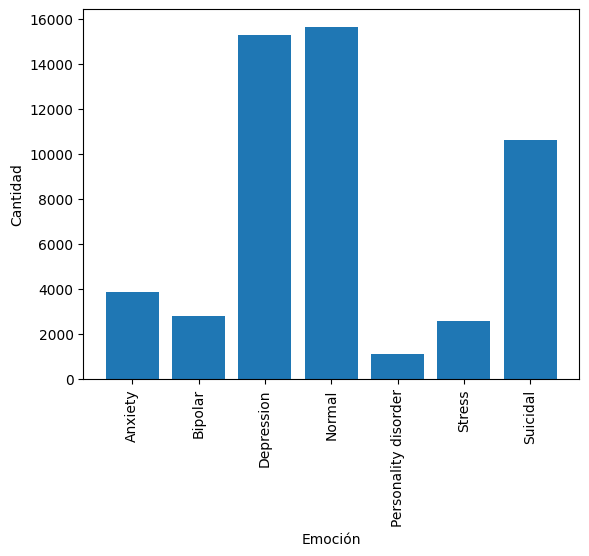

In [18]:
fig, ax = plt.subplots()
ax.bar(df_b.status, df_b.statement)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("Emoción")
ax.set_ylabel("Cantidad")
fig.show()

Como se puede observar, la mayoría de los datos están desbalanceados, a excepción de las etiquetas "Normal" y "Depression", también se oberva la etiqueta "Suicidal" con una cantidad lo suficientemente grande de documentos como para equipararla con las dos primeras.
Se evidencia la necesidad de aplicar técnicas de balanceo de datos para las demás etiquetas no mencionadas.

**Debido al tamaño reducido de la etiqueta "Personality disorder", tomamos la decisión de excluirla de los objetivos del proyecto con el fin de tener un modelo más eficiente utilizando las demás etiquetas que contienen una mayor cantidad de ejemplos.**

A continuación aplicamos las técnicas de balanceo (submuestreo, sobremuestreo) para las demás etiquetas:

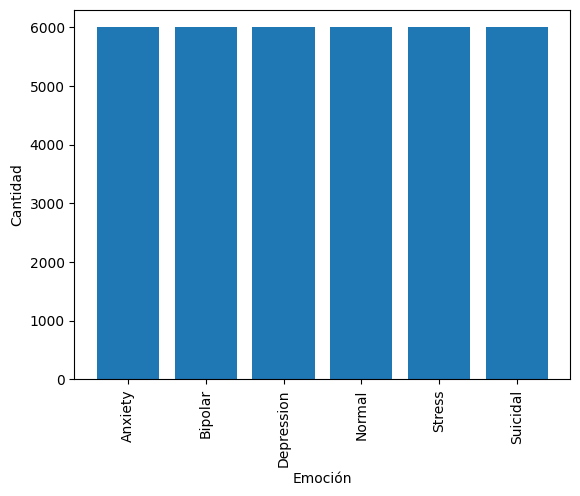

In [19]:
# para que siempre arroje los mismos registros
random_state = 0

# realizamos submuestreo a las etiquetas: "Normal", "Depression" y "Suicidal"
df_n = df[df.status == "Normal"]
df_d = df[df.status == "Depression"]
df_s = df[df.status == "Suicidal"]
df_n_sub = df_n.sample(6000, replace=True, random_state=random_state)
df_d_sub = df_d.sample(6000, replace=True, random_state=random_state)
df_s_sub = df_s.sample(6000, replace=True, random_state=random_state)

# realizamos submuestreo a las etiquetas: "Anxiety", "Bipolar" y "Stress"
df_a = df[df.status == "Anxiety"]
df_b = df[df.status == "Bipolar"]
df_ss = df[df.status == "Stress"]
df_a_sub = df_a.sample(6000, replace=True, random_state=random_state)
df_b_sub = df_b.sample(6000, replace=True, random_state=random_state)
df_ss_sub = df_ss.sample(6000, replace=True, random_state=random_state)

df = pd.concat([df_n_sub, df_d_sub, df_s_sub, df_a_sub, df_b_sub, df_ss_sub])

df_b = df.groupby(df.status, as_index=False).statement.count()

fig, ax = plt.subplots()
ax.bar(df_b.status, df_b.statement)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel("Emoción")
ax.set_ylabel("Cantidad")
fig.show()

Con este pre-procesamiento realizado podemos observar que todas las etiquetas en el alcance del proyecto tienen la misma cantidad de registros.

In [20]:
df.to_csv("combined_data-clean.csv")

### **1.4. Relación Entre Variables**
---

- Analice si existe alguna relación entre las variables. Puede utilizar medidas de correlación o visualizaciones.
- Identifique si hay redundancia entre las variables para una posterior eliminación o selección.

**Debido a la sencillez del dataset (2 variables, 1 identificador), no consideramos que sea necesario realizar un análisis de correlación entre variables, así mismo consideramos innecesario el análisis de redundancia entre las mismas.**

## **2. Limpieza de los Textos**
---

La selección de las técnicas de preprocesamiento del corpus puede variar en cada conjunto de datos. Recuerde que puede aplicar (no necesariamente todas) las técnicas generales vistas en el curso, tales como:

- Tokenizacion
- Normalización de textos.
- Limpieza con expresiones regulares.
- Lematización.
- Filtrado de palabras.
- Modificaciones en la grafía.

In [21]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
pat = re.compile(r"[^a-z' ]")
spaces = re.compile(r"\s{2,}")

def remove_patterns(text):
    # Remover links
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remover estilos markdown
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remover arrobas
    text = re.sub(r'@\w+', '', text)

    return text.strip()


def preprocess(text, min_len=1, max_len=23):
    text = remove_patterns(text)
    # Normalizamos el texto
    norm_text = unidecode(text)
    # Quitamos grafía
    lower_text = norm_text.lower()
    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, " ", lower_text)
    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    # Creamos documento de spacy
    doc = nlp(spaces_text.strip())
    # Eliminamos stopwords
    filtered_tokens = filter(lambda token: not token.is_stop, doc)
    # Filtramos palabras por longitud
    filtered_tokens2 = filter(lambda token: len(token) >= min_len and len(token) <= max_len, filtered_tokens)
    # Obtenemos los lemmas de cada token
    lemmas = map(lambda token: token.lemma_, filtered_tokens2)
    lemma_text = " ".join(lemmas)
    return lemma_text

Verificamos que la función realice bien su tarea:

In [23]:
prep_text = preprocess(df.statement.iloc[936])
print(df.statement.iloc[936])
print(prep_text)

Yes, obviously, if you choose a trustworthy leader, choose number one! greetings Mrs. Khofifah!
yes obviously choose trustworthy leader choose number greeting mrs khofifah


Aplicamos la funcion de preprocesamiento en todo el corpus para un mejor manejo:

In [24]:
### Este código puede ser demorado de ejecutar (aprox. 16 min)
prep_corpus = df.statement.apply(preprocess).tolist()
print(prep_corpus[:10])

['grave flower', 'snuggle bed little baby ahhhh', 'course match', 'ni ki good boy', 'drive schiphol apperantly stick aalsmeer', 'morning speak sun block outstation', 'gnite twitter world long day tomorrow night class till pm', 'look', 'tell finish', 'u like cravat diki']


In [34]:
df['preprocessed_text'] = prep_corpus
df.to_csv("PreprocessedDataset.csv")
df

,Unnamed: 0,statement,status,preprocessed_text
3717,3717,"Don't give the grave flowers, don't you?",Normal,grave flower
36050,36050,snuggling in bed with my little baby....ahhhh!,Normal,snuggle bed little baby ahhhh
33060,33060,of course they match.,Normal,course match
4337,4337,ni-ki best boy,Normal,ni ki good boy
42840,42840,driving to schiphol apperantly i am not the on...,Normal,drive schiphol apperantly stick aalsmeer
...,...,...,...,...
49413,49413,New years stress :-( Hi! I just need to tell t...,Stress,new year stress hi need tell somebody go ond h...
29250,29250,So I've recently started having anxiety attack...,Stress,recently start have anxiety attack hard breath...
28154,28154,"I have a short term plan, but nothing long ter...",Stress,short term plan long term assume go shut phone...
48603,48603,Stress making doing anything difficult I have ...,Stress,stress make difficult write essay study final ...


Implementamos un **CountVectorizer** con el fin de realizar un conteo de palabras de todo el corpus:

In [26]:
vect = (CountVectorizer(max_features=1000, max_df=0.7).fit(prep_corpus))
X = vect.transform(prep_corpus)
X_np = X.toarray()

Obtenemos los features que tenemos en todo el corpus:

In [27]:
vocab = vect.get_feature_names_out()
display(vocab)

array(['abilify', 'ability', 'able', 'absolutely', 'abuse', 'abusive',
       'accept', 'accident', 'account', 'ache', 'achieve', 'act',
       'action', 'activity', 'actual', 'actually', 'add', 'adhd', 'admit',
       'adult', 'advance', 'advice', 'affect', 'afford', 'afraid', 'age',
       'ago', 'agree', 'alcohol', 'alive', 'allow', 'alot', 'amazing',
       'amp', 'anger', 'angry', 'annoying', 'answer', 'anti',
       'antidepressant', 'anxiety', 'anxious', 'anybody', 'anymore',
       'anyways', 'apart', 'apartment', 'app', 'apparently', 'apply',
       'appointment', 'appreciate', 'area', 'arm', 'ashamed', 'ask',
       'asleep', 'ass', 'assume', 'attack', 'attempt', 'attention',
       'avoid', 'awake', 'aware', 'away', 'awful', 'baby', 'background',
       'bad', 'badly', 'barely', 'base', 'basic', 'basically', 'bathroom',
       'battle', 'bc', 'bear', 'beat', 'beautiful', 'bed', 'begin',
       'beginning', 'behavior', 'believe', 'benefit', 'bf', 'big', 'bill',
       'bipola

In [28]:
df_pt = pd.DataFrame(columns=vocab, data=X_np)
df_pt

,abilify,ability,able,absolutely,abuse,abusive,accept,accident,account,ache,...,worthless,write,wrong,yeah,year,yell,yes,yesterday,young,zoloft
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,4,0,0,0,0,0
35996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35998,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


Calculamos la cantidad de palabras en todo el corpus (máximo 1000 palabras)

In [31]:
df_res = df_pt.sum()
df_res = df_res.sort_values(kind='mergesort', ascending=False).head(10)
df_res

,0
feel,34372
like,28965
want,20955
know,20060
go,17569
time,17042
think,15611
life,14895
get,13854
day,13672


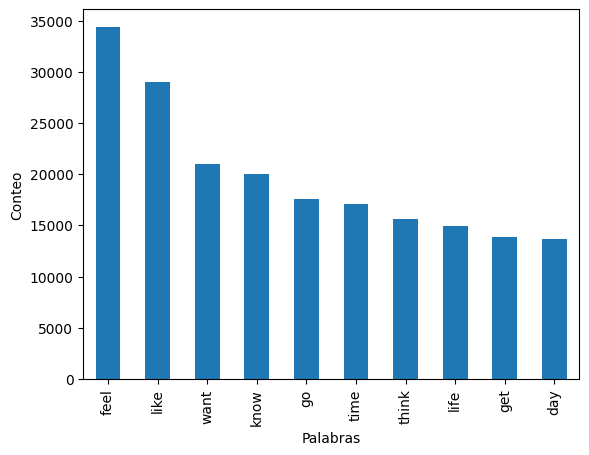

In [32]:
fig, ax = plt.subplots()
df_res.plot(kind="bar")
ax.set_xlabel("Palabras")
ax.set_ylabel("Conteo")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
fig.show()

Con esto podemos concluir mostrando la distribución de palabras en todo el corpus para posterior análisis.

## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*